In [160]:
import pandas as pd
pd.set_option('display.float_format', lambda x: '%.3f' % x)
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
import os
from itertools import combinations

import numpy as np
import pickle
import data

import importlib
importlib.reload(data)

from data import update_expl_data, update_target_data, food_categories, preprocess_expl
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

In [161]:
"""
Set sample rate. In this notebook, all data will be resampled at the chosen frequency.
'MS' : Monthly (Month Start)
'W' : Weekly
'D' : Daily
"""

year_period = {'MS': 12, 'W': 52, 'D': 365}
frequency = 'MS'
one_year = year_period[frequency]
output_path = "./output/ensemble_202110/"

In [162]:
"""
Load food CPI data from January 1986 to the most recently available data.
"""

foodprice_df = update_target_data(food_categories, './data_files/food_cpi.csv')
# foodprice_df = pd.read_csv("./data_files/food_cpi.csv")
# foodprice_df = foodprice_df.set_index("REF_DATE")
# foodprice_df.index = pd.DatetimeIndex(foodprice_df.index)
foodprice_df = foodprice_df.resample(frequency).mean().interpolate()
foodprice_df

Bakery and cereal products (excluding baby food)  \
REF_DATE                                                       
1986-01-01                                            69.300   
1986-02-01                                            70.300   
1986-03-01                                            70.600   
1986-04-01                                            71.300   
1986-05-01                                            71.200   
...                                                      ...   
2021-05-01                                           157.800   
2021-06-01                                           157.700   
2021-07-01                                           157.900   
2021-08-01                                           158.500   
2021-09-01                                           158.100   

            Dairy products and eggs  Fish, seafood and other marine products  \
REF_DATE                                                                       
1986-01-01                   70.900                                   60.600   
1986-02-01                   70.800                                   61.300   
1986-03-01                   71.100                                   61.300   
1986-04-01                   71.000                                   61.400   
1986-05-01                   71.400                                   61.900   
...                             ...                                      ...   
2021-05-01                  146.600                                  147.600   
2021-06-01                  145.300                                  146.200   
2021-07-01                  146.400                                  146.600   
2021-08-01                  148.300                                  146.800   
2021-09-01                  148.000                                  147.100   

            Food purchased from restaurants    Food  \
REF_DATE                                              
1986-01-01                           59.100  67.300   
1986-02-01                           59.100  66.900   
1986-03-01                           59.300  67.000   
1986-04-01                           59.700  67.700   
1986-05-01                           59.900  68.200   
...                                     ...     ...   
2021-05-01                          163.500 156.600   
2021-06-01                          163.900 156.800   
2021-07-01                          165.200 157.600   
2021-08-01                          165.900 158.000   
2021-09-01                          165.900 158.500   

            Fruit, fruit preparations and nuts    Meat  \
REF_DATE                                                 
1986-01-01                              76.000  65.100   
1986-02-01                              77.600  64.200   
1986-03-01                              79.200  64.200   
1986-04-01                              82.200  63.600   
1986-05-01                              83.500  64.000   
...                                        ...     ...   
2021-05-01                             143.900 175.400   
2021-06-01                             144.500 176.700   
2021-07-01                             141.700 180.900   
2021-08-01                             142.500 182.100   
2021-09-01                             141.500 184.800   

            Other food products and non-alcoholic beverages  \
REF_DATE                                                      
1986-01-01                                           77.500   
1986-02-01                                           78.100   
1986-03-01                                           78.600   
1986-04-01                                           79.500   
1986-05-01                                           79.800   
...                                                     ...   
2021-05-01                                          141.600   
2021-06-01                                          142.200   
2021-07-01                           

In [163]:
all_experiment_names = pd.Series(list(os.walk("./output"))[0][1])
all_experiment_names = all_experiment_names[~all_experiment_names.str.contains('ensemble')]
all_experiment_names

0     neuralprophet_202110_CPGRLE01CAM657N_nlags_24
1            neuralprophet_202110_CPIFABSL_nlags_48
2     neuralprophet_202110_IRLTLT01CAM156N_nlags_36
3                             nbeatsfredvars_202110
4             neuralprophet_202110_DEXCAUS_nlags_36
5            neuralprophet_202110_CPIFABSL_nlags_24
6              neuralprophet_202110_UNRATE_nlags_60
7              neuralprophet_202110_VXOCLS_nlags_36
8          neuralprophet_202110_DCOILWTICO_nlags_24
9          neuralprophet_202110_DCOILWTICO_nlags_48
10    neuralprophet_202110_LRUNTTTTCAM156S_nlags_60
11         neuralprophet_202110_QCAR368BIS_nlags_24
12    neuralprophet_202110_CPALCY01CAM661N_nlags_60
13     neuralprophet_202110_CUSR0000SAF113_nlags_24
14     neuralprophet_202110_CUSR0000SAF112_nlags_24
15     neuralprophet_202110_CUSR0000SAF113_nlags_48
16     neuralprophet_202110_CUSR0000SAF112_nlags_48
17         neuralprophet_202110_QCAR368BIS_nlags_36
18           neuralprophet_202110_FEDFUNDS_nlags_60
19     neura

In [164]:
# experiment_names = ["nbeatsfredvars_202110", "nbeats_202110", "prophet_202110", "neuralprophet_202110_DCOILWTICO_nlags_24"]
# experiment_names = ["nbeatsfredvars_202110", "nbeats_202110"]
# experiment_names = ["nbeats_202110", "prophet_202110"]
experiment_names = all_experiment_names.copy()
report_sim_dates = ["2015-07-01", "2016-07-01", "2017-07-01", "2018-07-01", "2019-07-01", "2020-07-01"]
sim_train_dates = {}
sim_valid_dates = {}

for date in report_sim_dates:
    sim_train_dates[date] = foodprice_df.index[foodprice_df.index <= date]
    sim_valid_dates[date] = foodprice_df.index[(foodprice_df.index > date) & (foodprice_df.index <= (pd.to_datetime(date) + pd.DateOffset(months=18)))]

In [165]:
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

metrics = {
    'r2_score': r2_score,
    'mae': mean_absolute_error,
    'mape': mean_absolute_percentage_error,
    'mse': mean_squared_error,
    'rmse': rmse
}

In [166]:
ex_name = "nbeats_202110"
sim_date = "2017-07-01"
fc = pd.read_csv(f"./output/{ex_name}/forecasts_{sim_date}.csv", index_col="REF_DATE")
fc.index = pd.DatetimeIndex(fc.index)
fc

Bakery and cereal products (excluding baby food)  \
REF_DATE                                                       
2017-08-01                                           153.709   
2017-09-01                                           153.161   
2017-10-01                                           151.943   
2017-11-01                                           152.833   
2017-12-01                                           153.270   
2018-01-01                                           155.047   
2018-02-01                                           153.534   
2018-03-01                                           154.664   
2018-04-01                                           154.002   
2018-05-01                                           154.583   
2018-06-01                                           154.570   
2018-07-01                                           156.502   
2018-08-01                                           155.905   
2018-09-01                                           155.447   
2018-10-01                                           154.674   
2018-11-01                                           154.227   
2018-12-01                                           156.073   
2019-01-01                                           155.752   

            Dairy products and eggs  Fish, seafood and other marine products  \
REF_DATE                                                                       
2017-08-01                  135.804                                  138.035   
2017-09-01                  135.938                                  137.329   
2017-10-01                  133.658                                  136.182   
2017-11-01                  135.240                                  136.894   
2017-12-01                  134.853                                  136.692   
2018-01-01                  136.309                                  137.341   
2018-02-01                  136.422                                  136.852   
2018-03-01                  136.844                                  137.627   
2018-04-01                  135.827                                  137.842   
2018-05-01                  136.871                                  138.206   
2018-06-01                  136.730                                  139.016   
2018-07-01                  138.140                                  139.756   
2018-08-01                  138.543                                  139.005   
2018-09-01                  138.503                                  139.359   
2018-10-01                  137.977                                  138.576   
2018-11-01                  136.595                                  136.391   
2018-12-01                  138.830                                  138.447   
2019-01-01                  138.102                                  137.320   

            Food purchased from restaurants    Food  \
REF_DATE                                              
2017-08-01                          146.632 144.145   
2017-09-01                          146.710 143.855   
2017-10-01                          146.055 142.547   
2017-11-01                          147.329 143.807   
2017-12-01                          148.907 145.633   
2018-01-01                          148.939 146.552   
2018-02-01                          148.660 146.041   
2018-03-01                          148.802 145.421   
2018-04-01                          149.567 146.662   
2018-05-01                          149.864 146.979   
2018-06-01                          149.918 147.271   
2018-07-01                          151.641 148.454   
2018-08-01                          150.884 148.101   
2018-09-01                          151.376 147.234   
2018-10-01                          152.329 147.300   
2018-11-01                          150.292 146.905   
2018-12-01                          152.861 149.004   
2019-01-01                          151.425 148.254   

            Fruit, fruit prep

In [167]:
def get_forecast_df(food_category, experiment_names, experiment_date):

    forecasts = []

    for ex_name in experiment_names:
        fc_df = pd.read_csv(f"./output/{ex_name}/forecasts_{experiment_date}.csv")
        if "REF_DATE" in fc_df.columns:
            fc_df = fc_df.set_index("REF_DATE")
        else:
            fc_df = fc_df.set_index("Unnamed: 0")
        fc_df.index = pd.DatetimeIndex(fc_df.index)
        fc_series = fc_df[food_category]
        fc_series = fc_series.rename(ex_name)
        forecasts.append(fc_series)

    return pd.concat(forecasts, axis=1)

In [168]:
get_forecast_df("Meat", experiment_names, "2017-07-01")

neuralprophet_202110_CPGRLE01CAM657N_nlags_24  \
2017-08-01                                        164.292   
2017-09-01                                        166.032   
2017-10-01                                        165.544   
2017-11-01                                        166.853   
2017-12-01                                        168.815   
2018-01-01                                        168.909   
2018-02-01                                        171.905   
2018-03-01                                        171.913   
2018-04-01                                        172.788   
2018-05-01                                        175.488   
2018-06-01                                        175.468   
2018-07-01                                        177.898   
2018-08-01                                        178.159   
2018-09-01                                        178.567   
2018-10-01                                        179.561   
2018-11-01                                        180.151   
2018-12-01                                        179.830   
2019-01-01                                        181.056   

            neuralprophet_202110_CPIFABSL_nlags_48  \
2017-08-01                                 162.604   
2017-09-01                                 163.898   
2017-10-01                                 164.316   
2017-11-01                                 166.681   
2017-12-01                                 167.769   
2018-01-01                                 167.947   
2018-02-01                                 169.839   
2018-03-01                                 170.021   
2018-04-01                                 170.886   
2018-05-01                                 172.450   
2018-06-01                                 174.244   
2018-07-01                                 175.216   
2018-08-01                                 173.180   
2018-09-01                                 173.995   
2018-10-01                                 174.849   
2018-11-01                                 175.721   
2018-12-01                                 176.243   
2019-01-01                                 175.537   

            neuralprophet_202110_IRLTLT01CAM156N_nlags_36  \
2017-08-01                                        164.119   
2017-09-01                                        165.736   
2017-10-01                                        165.996   
2017-11-01                                        167.651   
2017-12-01                                        169.007   
2018-01-01                                        171.158   
2018-02-01                                        173.130   
2018-03-01                                        173.386   
2018-04-01                                        176.447   
2018-05-01                                        176.190   
2018-06-01                                        179.530   
2018-07-01                                        181.084   
2018-08-01                                        181.203   
2018-09-01                                        181.094   
2018-10-01                                        182.395   
2018-11-01                                        183.635   
2018-12-01                                        183.189   
2019-01-01                                        184.704   

            nbeatsfredvars_202110  neuralprophet_202110_DEXCAUS_nlags_36  \
2017-08-01                157.768                                167.462   
2017-09-01                157.912                                165.665   
2017-10-01                159.119                                167.379   
2017-11-01                158.290                                167.980   
2017-12-01                157.527                                167.318   
2018-01-01                159.626                                170.157   
2018-02-01                159.230                                171.574   
2018-03-01                159.800                        

In [169]:
def eval_mean_forecast(foodprice_df, food_category, experiment_date, valid_dates):
      
    valid_series = foodprice_df.loc[valid_dates][food_category]                                 # Select the validation data. 
    all_forecasts = get_forecast_df(food_category, experiment_names, experiment_date)       # Produce the validation period forecast.
    mean_forecast = all_forecasts.mean(axis=1)
    std_forecast =  all_forecasts.std(axis=1)

    valid_metrics = {metric_name: metric_fn(y_true=valid_series,                        # Compute validation metrics. 
                                      y_pred=mean_forecast) for metric_name, metric_fn in metrics.items()}

    return valid_series, mean_forecast, std_forecast, valid_metrics

## Ensemble and evaluate forecasts

In [170]:
all_valid_metrics = {}
all_forecasts = {}

for report_sim_date in report_sim_dates:

    food_forecasts = {}
    food_scores = {}

    for category in food_categories:
        actual, fc, fc_std, scores = eval_mean_forecast(foodprice_df, category, date, sim_valid_dates[date])
        food_scores[category] = scores
        food_forecasts[category] = fc
        
    all_valid_metrics[report_sim_date] = food_scores
    all_forecasts[report_sim_date] = food_forecasts

In [171]:
valid_metrics_concat = {}

all_valid_metrics.keys()

for report_date, valid_scores in all_valid_metrics.items():
    valid_metrics_concat[report_date] = pd.DataFrame(valid_scores).T
index = valid_metrics_concat[report_date].index
columns = valid_metrics_concat[report_date].columns
scores = [df.values for date, df in valid_metrics_concat.items()]
mean_scores = pd.DataFrame(np.array(scores).mean(axis=0), index=index, columns=columns)
# mean_scores.to_csv(f"{output_path}/mean_fc_valid_metrics.csv")
mean_scores

r2_score   mae  mape    mse  \
Bakery and cereal products (excluding baby food)   -12.196 4.185 0.027 20.224   
Dairy products and eggs                             -6.533 6.864 0.047 52.627   
Fish, seafood and other marine products            -11.149 4.704 0.032 24.132   
Food purchased from restaurants                      0.527 1.031 0.006  1.315   
Food                                                -1.879 2.785 0.018  9.275   
Fruit, fruit preparations and nuts                  -1.479 2.326 0.016  7.070   
Meat                                                 0.000 3.433 0.019 25.597   
Other food products and non-alcoholic beverages     -0.879 2.712 0.019 11.164   
Vegetables and vegetable preparations               -1.790 5.748 0.037 42.432   

                                                  rmse  
Bakery and cereal products (excluding baby food) 4.497  
Dairy products and eggs                          7.254  
Fish, seafood and other marine products          4.912  
Food purchased from restaurants                  1.147  
Food                                             3.045  
Fruit, fruit preparations and nuts               2.659  
Meat                                             5.059  
Other food products and non-alcoholic beverages  3.341  
Vegetables and vegetable preparations            6.514

## Visualize All Forecasts

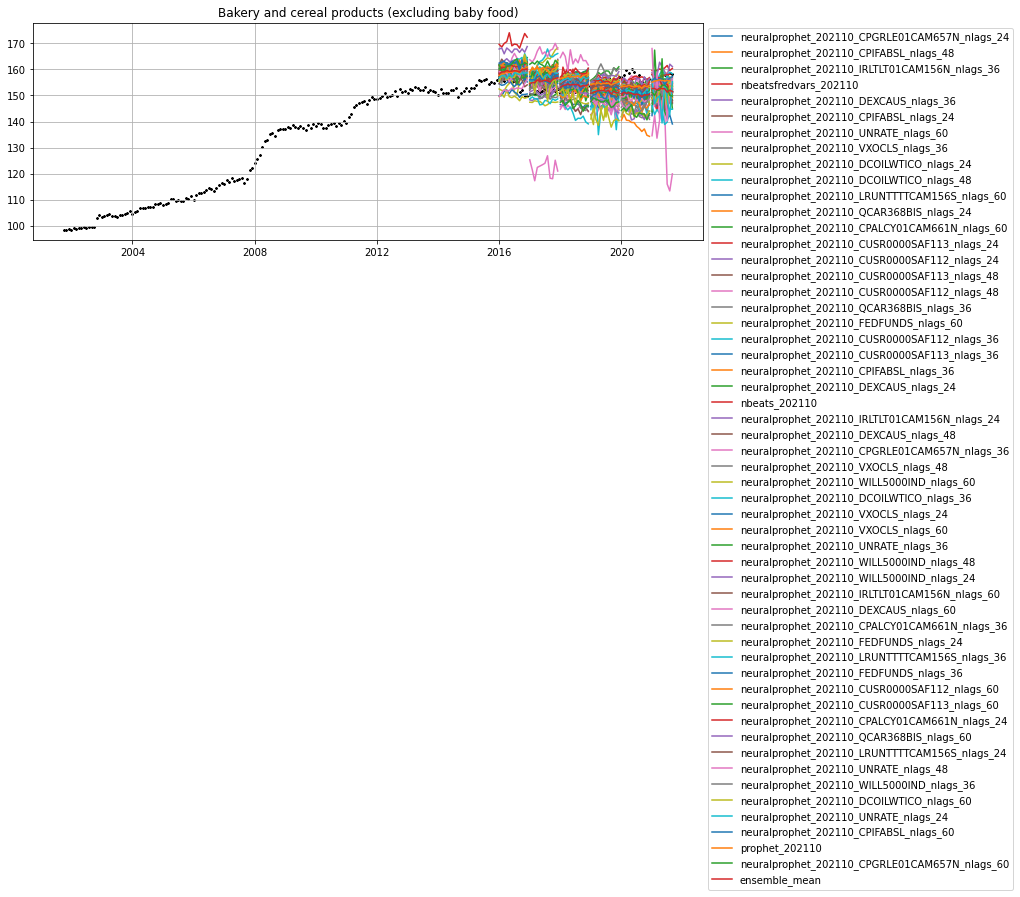

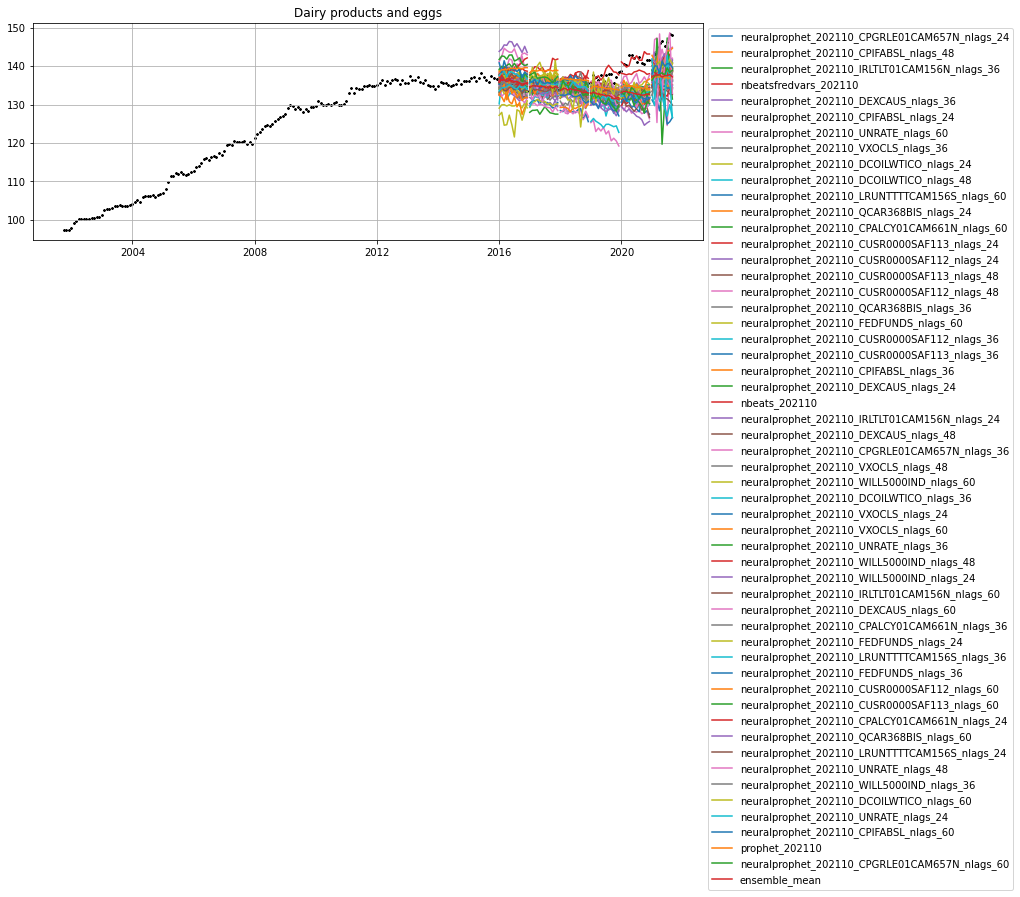

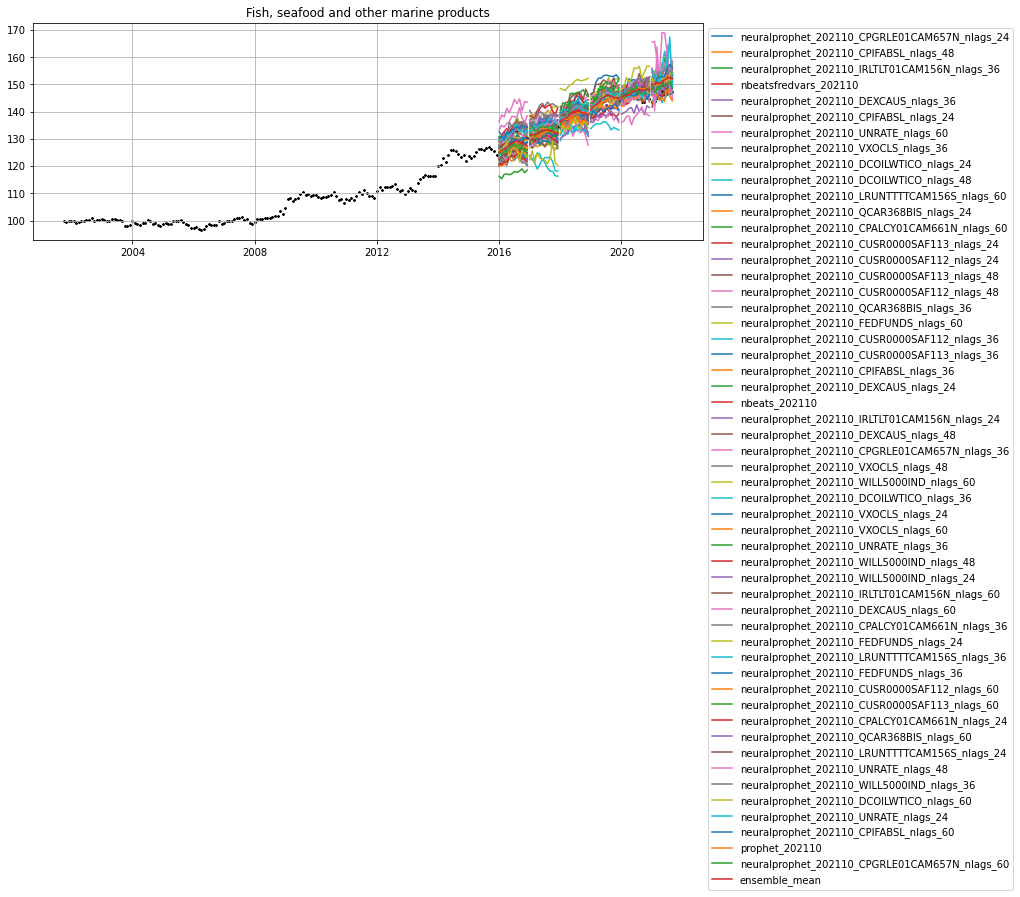

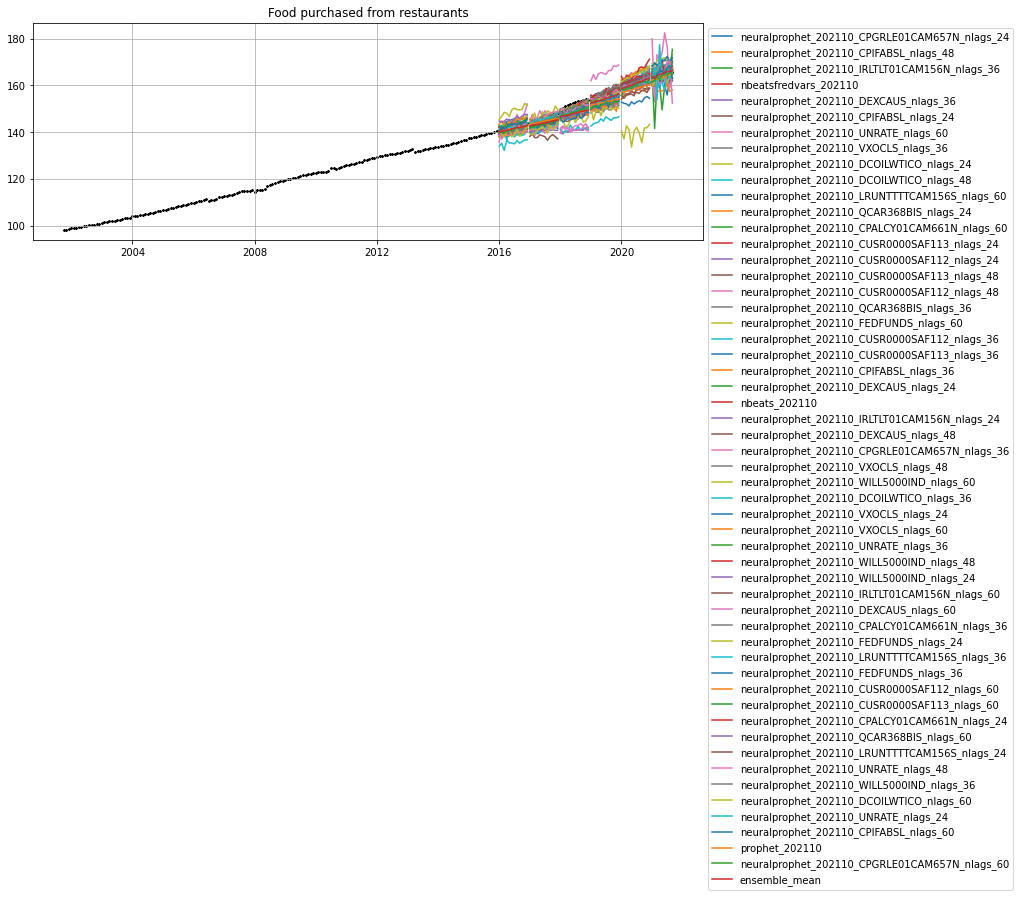

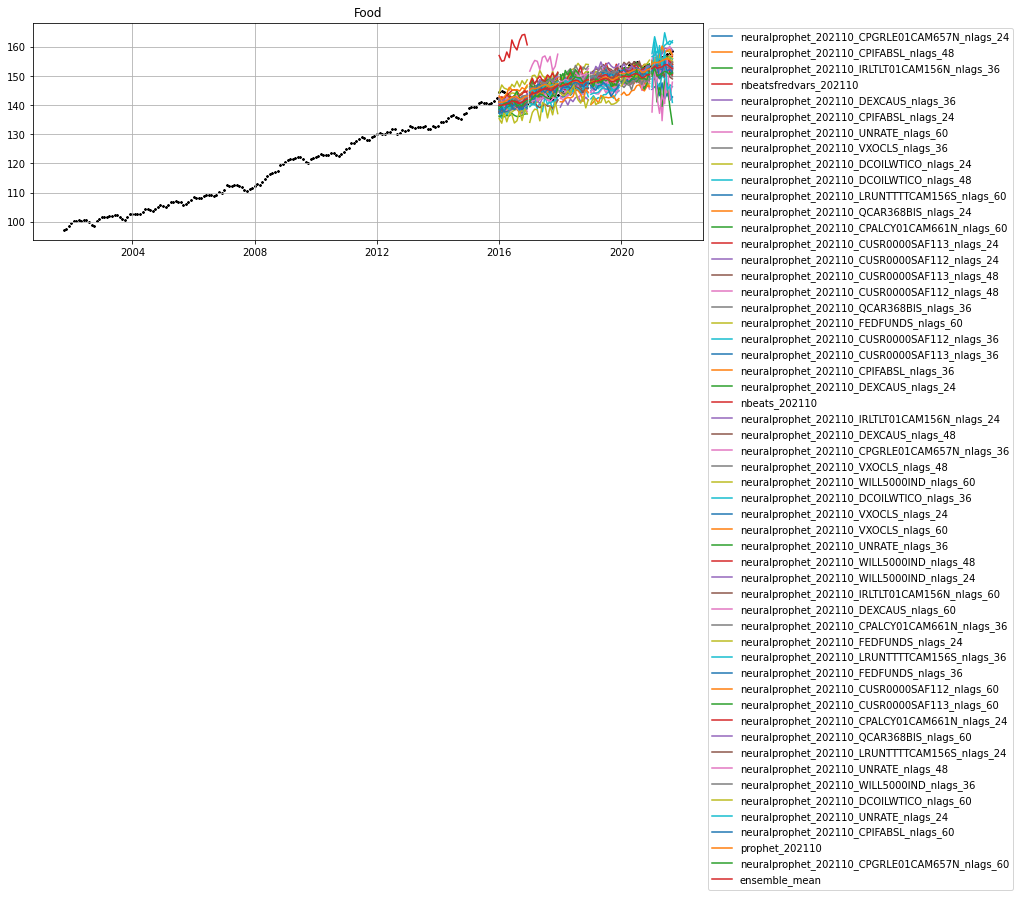

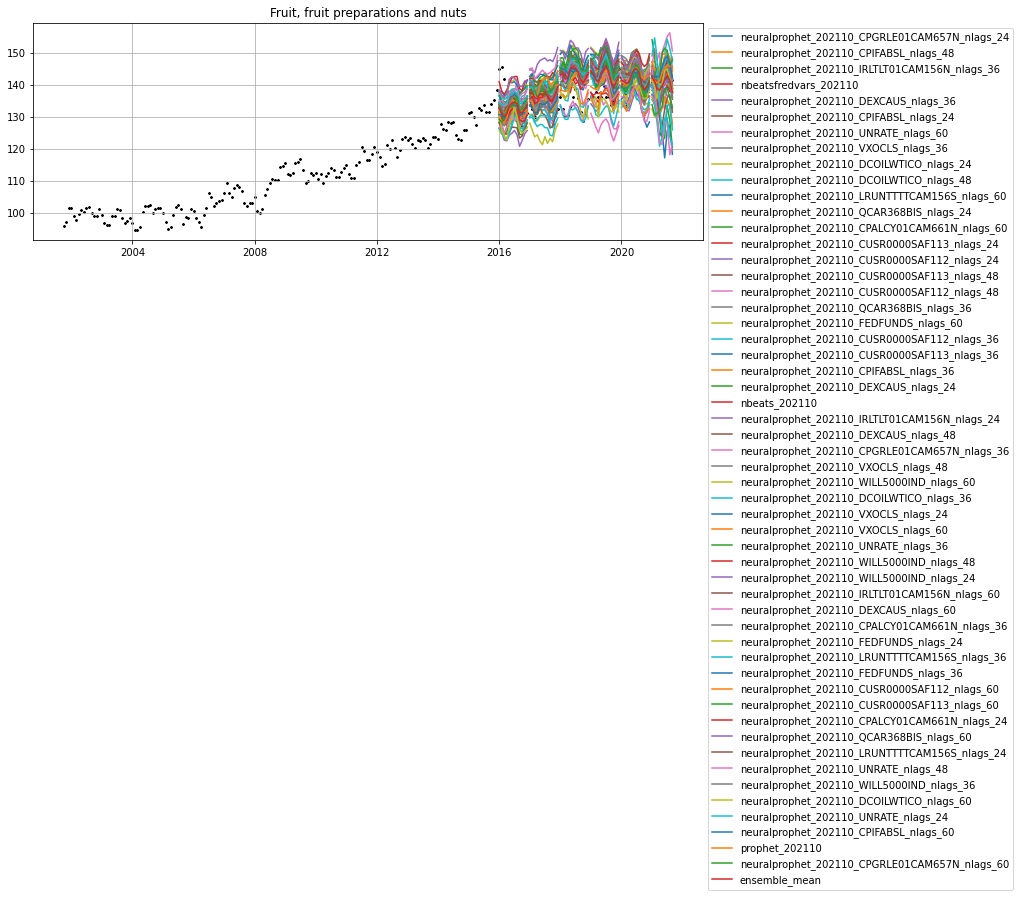

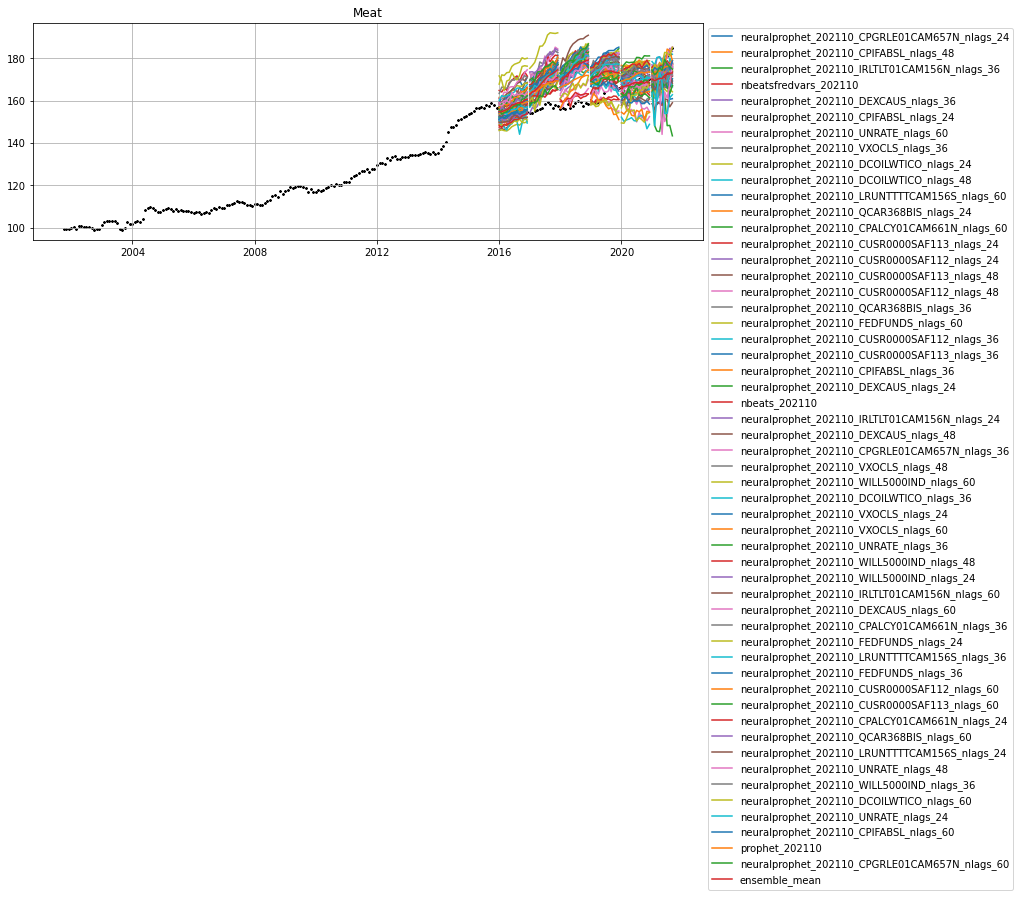

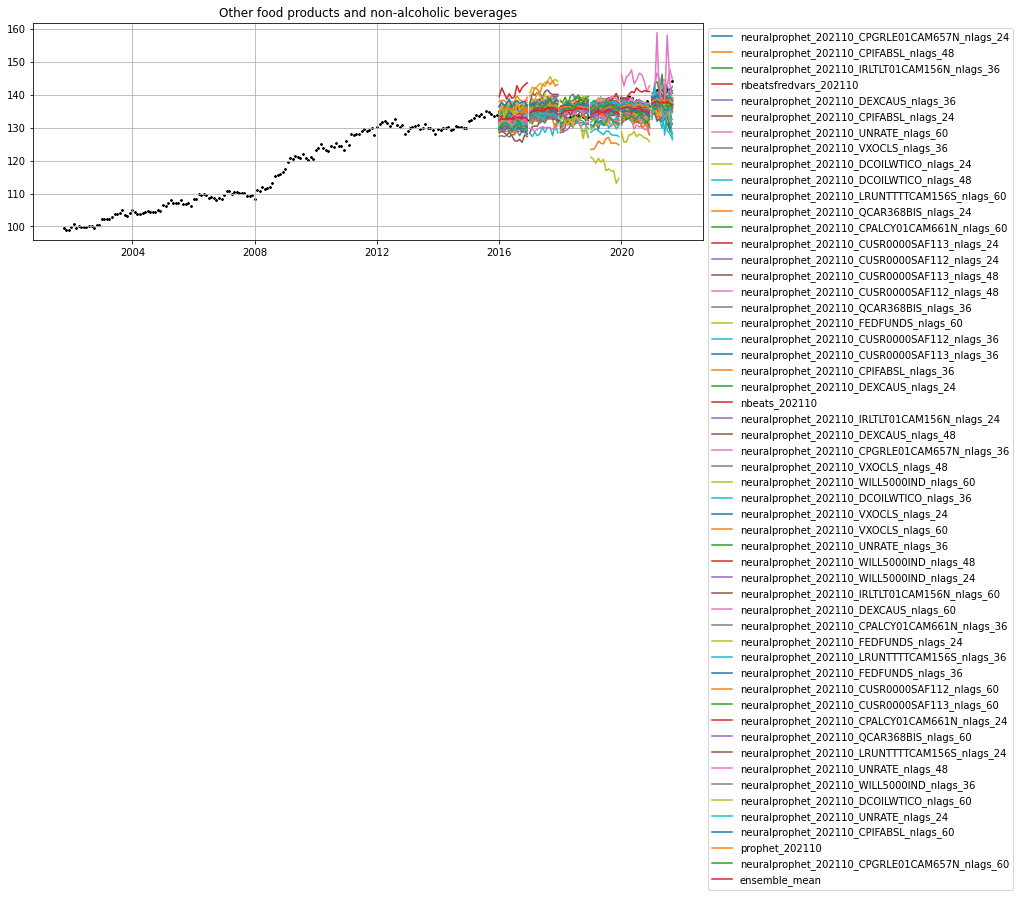

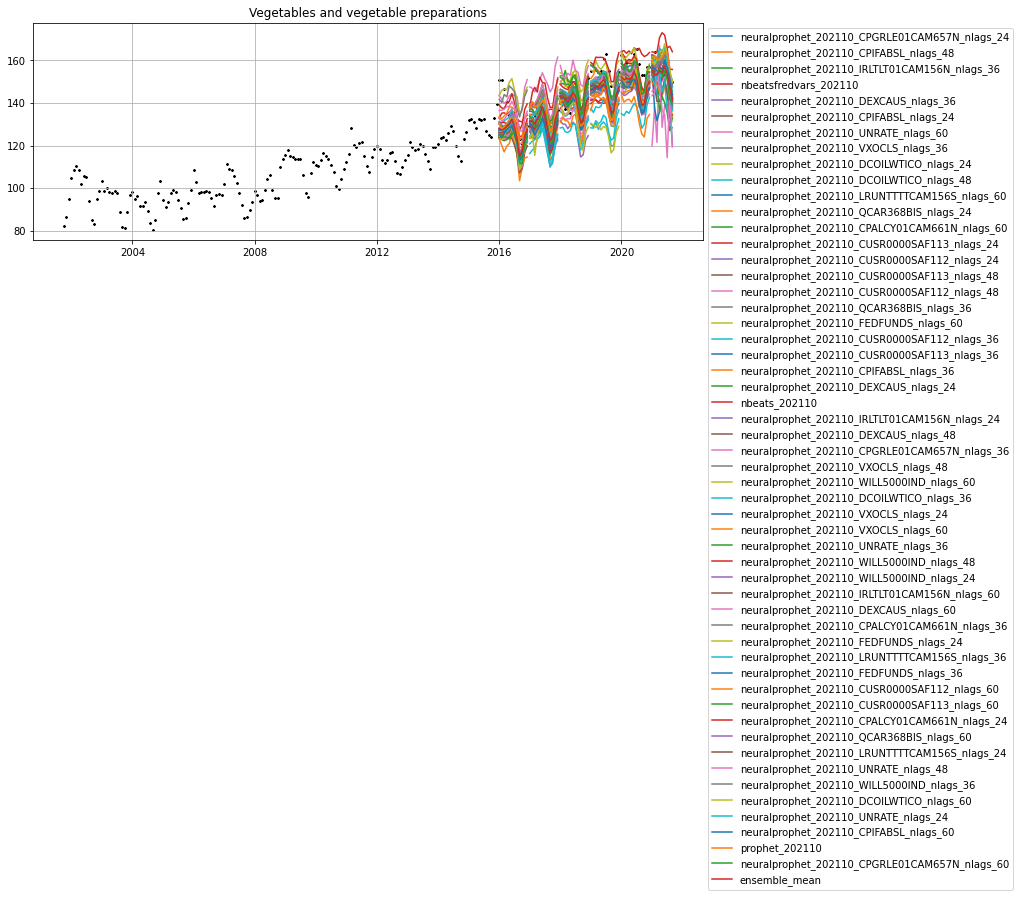

In [209]:
food_col_stats = {}

for category in food_categories:

    fig, ax = plt.subplots(figsize=(12,4))
    date_stats = []

    for d_index, date in enumerate(report_sim_dates):

        all_forecasts = get_forecast_df(category, experiment_names, date)
        all_forecasts = all_forecasts.loc[all_forecasts.index >= pd.to_datetime(date) + pd.DateOffset(months=6)]
        all_forecasts = all_forecasts.loc[all_forecasts.index < pd.to_datetime(date) + pd.DateOffset(months=18)]
        all_forecasts = all_forecasts.assign(ensemble_mean=all_forecasts.mean(axis=1))

        ax.scatter(foodprice_df[category].index[-240:], foodprice_df[category].iloc[-240:], color='black', s=1)

        col_stats = {}

        for index, col in enumerate(all_forecasts):

            # Collect some stats
            y_pred = all_forecasts[col]
            y_true = foodprice_df[category].loc[y_pred.index]
            col_stats[col] = y_pred - y_true

            if d_index < 1:
                ax.plot(all_forecasts[col], color=f"C{index}", label=col)
            else:
                ax.plot(all_forecasts[col], color=f"C{index}")

        date_stats.append(pd.DataFrame(col_stats))
    
    food_col_stats[category] = pd.concat(date_stats, axis=0)

    plt.title(category)
    plt.legend(bbox_to_anchor=(1,1))
    plt.grid()
    # plt.savefig(f"./report_output/ensemble_raw_{category}.svg", bbox_inches='tight')
    plt.show()


In [210]:
from scipy.stats import ttest_1samp

all_t_stats = []

for col in food_col_stats:
    for exp_col in food_col_stats[col]:

        errors = food_col_stats[col][exp_col].dropna(axis=0).values
        t_stat, p_value = ttest_1samp(errors, popmean=0)
        # print(col, exp_col, t_stat, p_value)
        all_t_stats.append({"Category": col, "Experiment": exp_col, 't_statistic': t_stat, 'p_value': p_value})

In [211]:
pd.DataFrame(all_t_stats)

Category  \
0    Bakery and cereal products (excluding baby food)   
1    Bakery and cereal products (excluding baby food)   
2    Bakery and cereal products (excluding baby food)   
3    Bakery and cereal products (excluding baby food)   
4    Bakery and cereal products (excluding baby food)   
..                                                ...   
481             Vegetables and vegetable preparations   
482             Vegetables and vegetable preparations   
483             Vegetables and vegetable preparations   
484             Vegetables and vegetable preparations   
485             Vegetables and vegetable preparations   

                                        Experiment  t_statistic  p_value  
0    neuralprophet_202110_CPGRLE01CAM657N_nlags_24        3.566    0.001  
1           neuralprophet_202110_CPIFABSL_nlags_48        1.452    0.151  
2    neuralprophet_202110_IRLTLT01CAM156N_nlags_36       -1.436    0.156  
3                            nbeatsfredvars_202110        3.609    0.001  
4            neuralprophet_202110_DEXCAUS_nlags_36        0.905    0.369  
..                                             ...          ...      ...  
481           neuralprophet_202110_UNRATE_nlags_24       -5.315    0.000  
482         neuralprophet_202110_CPIFABSL_nlags_60       -8.697    0.000  
483                                 prophet_202110       -4.306    0.000  
484  neuralprophet_202110_CPGRLE01CAM657N_nlags_60       -4.743    0.000  
485                                  ensemble_mean       -7.283    0.000  

[486 rows x 4 columns]

## Visualize Mean Forecasts

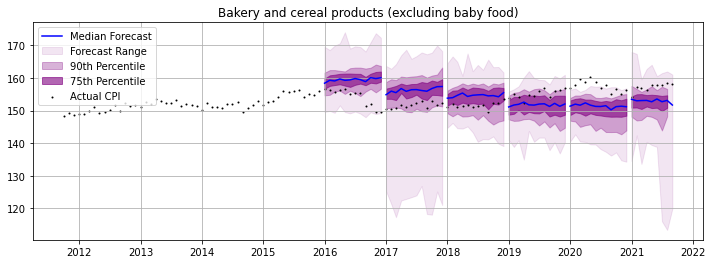

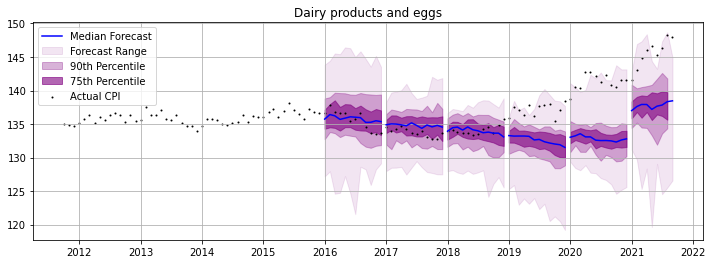

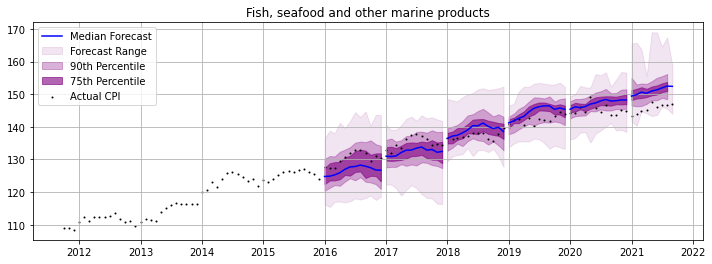

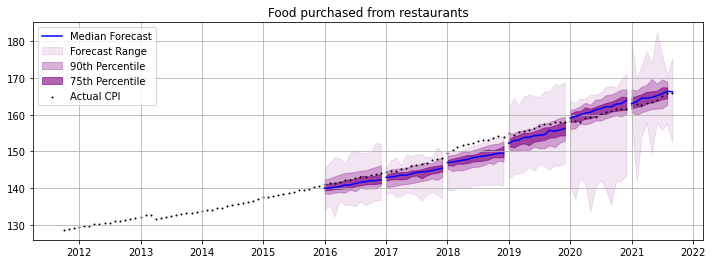

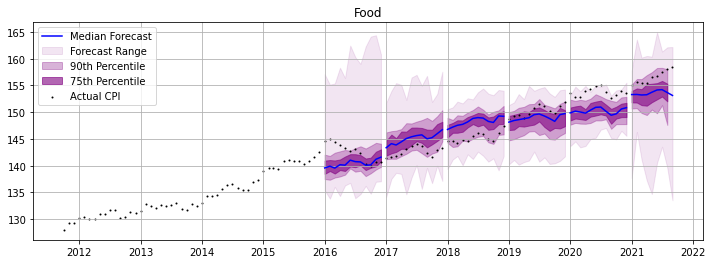

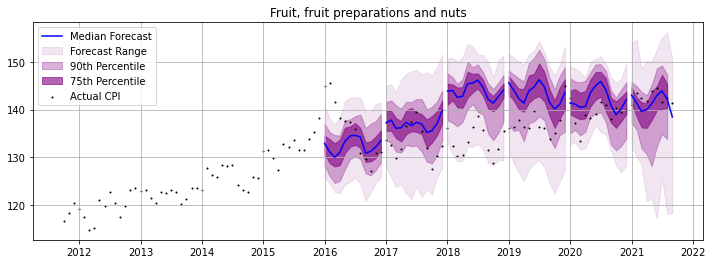

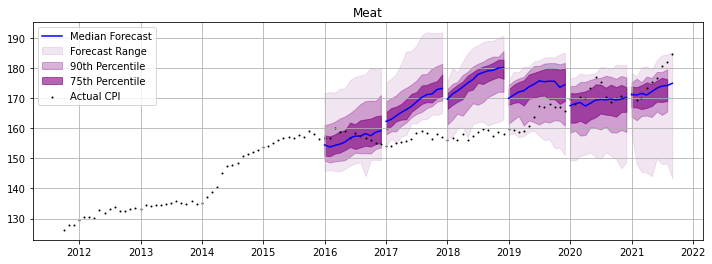

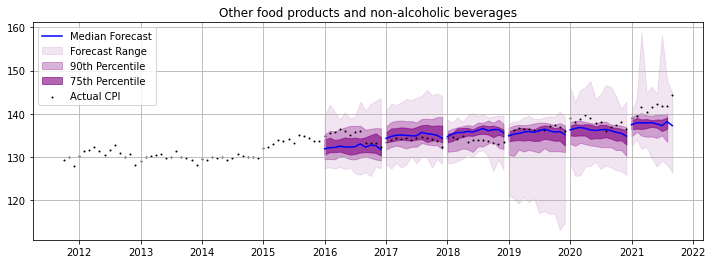

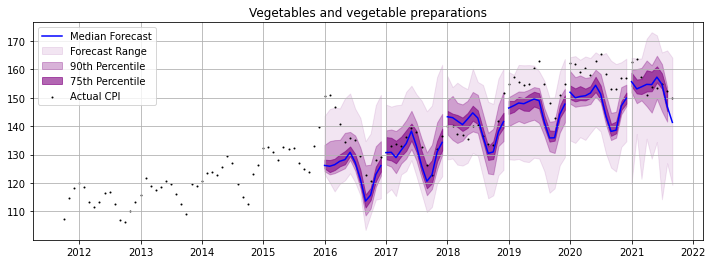

In [212]:
for category in food_categories:

    fig, ax = plt.subplots(figsize=(12,4))

    for d_index, date in enumerate(report_sim_dates):

        all_forecasts = get_forecast_df(category, experiment_names, date)
        all_forecasts = all_forecasts.loc[all_forecasts.index >= pd.to_datetime(date) + pd.DateOffset(months=6)]
        all_forecasts = all_forecasts.loc[all_forecasts.index < pd.to_datetime(date) + pd.DateOffset(months=18)]

        forecast_min = np.min(all_forecasts, axis=1) 
        forecast_10 = np.percentile(all_forecasts, 10, axis=1)
        forecast_25 = np.percentile(all_forecasts, 25, axis=1)
        forecast_75 = np.percentile(all_forecasts, 75, axis=1)
        forecast_90 = np.percentile(all_forecasts, 90, axis=1)
        forecast_max = np.max(all_forecasts, axis=1) 

        if d_index < 1:
            # ax.plot(all_forecasts.index, all_forecasts.mean(axis=1), color='red', label='Mean Forecast')
            ax.plot(all_forecasts.index, all_forecasts.median(axis=1), color='blue', label='Median Forecast')
            ax.fill_between(all_forecasts.index, forecast_min, forecast_max, alpha=0.1, color='purple', label='Forecast Range')
            ax.fill_between(all_forecasts.index, forecast_10, forecast_90, alpha=0.3, color='purple', label='90th Percentile')
            ax.fill_between(all_forecasts.index, forecast_25, forecast_75, alpha=0.6, color='purple', label='75th Percentile')
        else:
            # ax.plot(all_forecasts.index, all_forecasts.mean(axis=1), color='red')
            ax.plot(all_forecasts.index, all_forecasts.median(axis=1), color='blue')
            ax.fill_between(all_forecasts.index, forecast_min, forecast_max, alpha=0.1, color='purple')
            ax.fill_between(all_forecasts.index, forecast_10, forecast_90, alpha=0.3, color='purple')
            ax.fill_between(all_forecasts.index, forecast_25, forecast_75, alpha=0.6, color='purple')

    ax.scatter(foodprice_df[category].index[-120:], foodprice_df[category].iloc[-120:], color='black', s=1, label="Actual CPI")
    plt.title(category)
    plt.legend(loc='upper left')
    plt.grid()
    # plt.savefig(f"./report_output/ensemble_range_{category}.svg", bbox_inches='tight')
    plt.show()


## Search for the best-validating ensembles per-category over the whole validation period

With the multivariate NeuralProphet models, there are now many model configurations to choose from. Which ones should be combined and ensembled? Let's do this in a completely systematic way and find the configuration that validates best. We'll do this separately for each food price category.

In [177]:
all_combinations = []

for c_size in range(1, 4):
    for exp in combinations(experiment_names, c_size):
        all_combinations.append(exp)

print(len(all_combinations))

24857


In [178]:
category_config_scores = {}

for category in food_categories:

    print(f"Computing ensemble scores for {category}")

    config_scores = {}
    config_stddevs = {}

    for config_index, exp_config in enumerate(all_combinations):

        if config_index % 100 == 0:
            print(f"Processing config {config_index + 1} of {len(all_combinations)}...")

        valid_date_errors = []

        for d_index, date in enumerate(report_sim_dates):

            all_forecasts = get_forecast_df(category, exp_config, date)

            all_forecasts = all_forecasts.loc[all_forecasts.index >= pd.to_datetime(date) + pd.DateOffset(months=6)]
            all_forecasts = all_forecasts.loc[all_forecasts.index < pd.to_datetime(date) + pd.DateOffset(months=18)]

            mean_forecast = all_forecasts.mean(axis=1)
            actual_cpi = foodprice_df[category][mean_forecast.index]

            analysis_df = pd.DataFrame({'y': actual_cpi, 'yhat': mean_forecast})
            valid_date_errors.append(mean_absolute_percentage_error(y_true=analysis_df.y, y_pred=analysis_df.yhat))

        mean_mape = np.mean(valid_date_errors)
        std_mape = np.std(valid_date_errors)
        config_scores[str(exp_config)] = mean_mape
        config_stddevs[str(exp_config)] = std_mape
        
    category_config_scores[category] =  pd.DataFrame({'mape': config_scores, 'stddev': config_stddevs})  # pd.Series(config_scores, name='mape').to_frame()

Computing ensemble scores for Bakery and cereal products (excluding baby food)
Processing config 1 of 24857...
Processing config 101 of 24857...
Processing config 201 of 24857...
Processing config 301 of 24857...
Processing config 401 of 24857...
Processing config 501 of 24857...
Processing config 601 of 24857...
Processing config 701 of 24857...
Processing config 801 of 24857...
Processing config 901 of 24857...
Processing config 1001 of 24857...
Processing config 1101 of 24857...
Processing config 1201 of 24857...
Processing config 1301 of 24857...
Processing config 1401 of 24857...
Processing config 1501 of 24857...
Processing config 1601 of 24857...
Processing config 1701 of 24857...
Processing config 1801 of 24857...
Processing config 1901 of 24857...
Processing config 2001 of 24857...
Processing config 2101 of 24857...
Processing config 2201 of 24857...
Processing config 2301 of 24857...
Processing config 2401 of 24857...
Processing config 2501 of 24857...
Processing config 2601 

In [179]:
# pickle.dump(category_config_scores, open("./all_validation_mapes_large.pkl", 'wb'))

<AxesSubplot:ylabel='Frequency'>

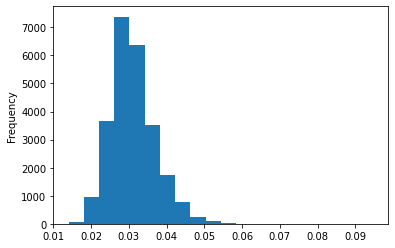

In [213]:
category_config_scores['Bakery and cereal products (excluding baby food)'].mape.plot(kind='hist', bins=20)

In [215]:
for category in food_categories:
    ensemble_results = category_config_scores[category].sort_values('mape')
    ensemble_results.to_csv(f"./report_output/ensemble_scores_{category}.csv")

In [220]:
category_config_scores["Meat"].head(60)

mape  stddev
('neuralprophet_202110_CPGRLE01CAM657N_nlags_24',) 0.059   0.035
('neuralprophet_202110_CPIFABSL_nlags_48',)        0.049   0.027
('neuralprophet_202110_IRLTLT01CAM156N_nlags_36',) 0.066   0.041
('nbeatsfredvars_202110',)                         0.027   0.010
('neuralprophet_202110_DEXCAUS_nlags_36',)         0.060   0.047
('neuralprophet_202110_CPIFABSL_nlags_24',)        0.057   0.028
('neuralprophet_202110_UNRATE_nlags_60',)          0.056   0.035
('neuralprophet_202110_VXOCLS_nlags_36',)          0.057   0.036
('neuralprophet_202110_DCOILWTICO_nlags_24',)      0.055   0.027
('neuralprophet_202110_DCOILWTICO_nlags_48',)      0.059   0.033
('neuralprophet_202110_LRUNTTTTCAM156S_nlags_60',) 0.070   0.026
('neuralprophet_202110_QCAR368BIS_nlags_24',)      0.061   0.036
('neuralprophet_202110_CPALCY01CAM661N_nlags_60',) 0.050   0.030
('neuralprophet_202110_CUSR0000SAF113_nlags_24',)  0.049   0.034
('neuralprophet_202110_CUSR0000SAF112_nlags_24',)  0.041   0.018
('neuralprophet_202110_CUSR0000SAF113_nlags_48',)  0.062   0.036
('neuralprophet_202110_CUSR0000SAF112_nlags_48',)  0.054   0.030
('neuralprophet_202110_QCAR368BIS_nlags_36',)      0.061   0.040
('neuralprophet_202110_FEDFUNDS_nlags_60',)        0.068   0.040
('neuralprophet_202110_CUSR0000SAF112_nlags_36',)  0.059   0.040
('neuralprophet_202110_CUSR0000SAF113_nlags_36',)  0.060   0.041
('neuralprophet_202110_CPIFABSL_nlags_36',)        0.056   0.031
('neuralprophet_202110_DEXCAUS_nlags_24',)         0.054   0.034
('nbeats_202110',)                                 0.032   0.014
('neuralprophet_202110_IRLTLT01CAM156N_nlags_24',) 0.057   0.040
('neuralprophet_202110_DEXCAUS_nlags_48',)         0.071   0.042
('neuralprophet_202110_CPGRLE01CAM657N_nlags_36',) 0.061   0.041
('neuralprophet_202110_VXOCLS_nlags_48',)          0.079   0.038
('neuralprophet_202110_WILL5000IND_nlags_60',)     0.110   0.049
('neuralprophet_202110_DCOILWTICO_nlags_36',)      0.056   0.019
('neuralprophet_202110_VXOCLS_nlags_24',)          0.055   0.038
('neuralprophet_202110_VXOCLS_nlags_60',)          0.056   0.036
('neuralprophet_202110_UNRATE_nlags_36',)          0.081   0.047
('neuralprophet_202110_WILL5000IND_nlags_48',)     0.069   0.045
('neuralprophet_202110_WILL5000IND_nlags_24',)     0.055   0.038
('neuralprophet_202110_IRLTLT01CAM156N_nlags_60',) 0.087   0.047
('neuralprophet_202110_DEXCAUS_nlags_60',)         0.052   0.040
('neuralprophet_202110_CPALCY01CAM661N_nlags_36',) 0.060   0.043
('neuralprophet_202110_FEDFUNDS_nlags_24',)        0.064   0.036
('neuralprophet_202110_LRUNTTTTCAM156S_nlags_36',) 0.066   0.038
('neuralprophet_202110_FEDFUNDS_nlags_36',)        0.072   0.046
('neuralprophet_202110_CUSR0000SAF112_nlags_60',)  0.054   0.030
('neuralprophet_202110_CUSR0000SAF113_nlags_60',)  0.067   0.037
('neuralprophet_202110_CPALCY01CAM661N_nlags_24',) 0.060   0.032
('neuralprophet_202110_QCAR368BIS_nlags_60',)      0.060   0.046
('neuralprophet_202110_LRUNTTTTCAM156S_nlags_24',) 0.058   0.033
('neuralprophet_202110_UNRATE_nlags_48',)          0.057   0.024
('neuralprophet_202110_WILL5000IND_nlags_36',)     0.072   0.038
('neuralprophet_202110_DCOILWTICO_nlags_60',)      0.049   0.023
('neuralprophet_202110_UNRATE_nlags_24',)          0.064   0.039
('neuralprophet_202110_CPIFABSL_nlags_60',)        0.056   0.035
('prophet_202110',)                                0.038   0.024
('neuralprophet_202110_CPGRLE01CAM657N_nlags_60',) 0.048   0.043
('neuralprophet_202110_CPGRLE01CAM657N_nlags_24... 0.050   0.035
('neuralprophet_202110_CPGRLE01CAM657N_nlags_24... 0.062   0.038
('neuralprophet_202110_CPGRLE01CAM657N_nlags_24... 0.034   0.020
('neuralprophet_202110_CPGRLE01CAM657N_nlags_24... 0.059   0.040
('neuralprophet_202110_CPGRLE01CAM657N_nlags_24... 0.058   0.031
('neuralprophet_202110_CPGRLE01CAM657N_nlags_24... 0.051   0.023
('neuralprophet_202110_CPGRLE01CAM657N_nlags_24... 0.053   0.039

In [223]:
category_config_scores["Vegetables and vegetable preparations"].sort_values('mape')

mape  stddev
('neuralprophet_202110_DEXCAUS_nlags_24', 'neur... 0.029   0.012
('nbeatsfredvars_202110', 'neuralprophet_202110... 0.029   0.015
('neuralprophet_202110_WILL5000IND_nlags_60', '... 0.029   0.008
('nbeatsfredvars_202110', 'neuralprophet_202110... 0.030   0.011
('neuralprophet_202110_WILL5000IND_nlags_60', '... 0.030   0.010
...                                                  ...     ...
('neuralprophet_202110_DCOILWTICO_nlags_48',)      0.084   0.045
('neuralprophet_202110_CUSR0000SAF112_nlags_24'... 0.085   0.035
('neuralprophet_202110_DCOILWTICO_nlags_48', 'n... 0.086   0.044
('neuralprophet_202110_CUSR0000SAF112_nlags_36',)  0.092   0.049
('neuralprophet_202110_UNRATE_nlags_60',)          0.092   0.036

[24857 rows x 2 columns]

In [224]:
results = {}
for category in food_categories:
    best_exp_config = category_config_scores[category].idxmin()['mape']
    best_exp_config = best_exp_config.replace("'",'').replace(' ', '').strip('()').split(',')
    results[category] = best_exp_config
    print(f"{category}\t{best_exp_config}\t{category_config_scores[category]['mape'].min()}\t{category_config_scores[category].sort_values('mape')['stddev'][0]}")

Bakery and cereal products (excluding baby food)	['neuralprophet_202110_IRLTLT01CAM156N_nlags_36', 'nbeatsfredvars_202110', 'neuralprophet_202110_CUSR0000SAF112_nlags_24']	0.014008609097695026	0.008770144190252646
Dairy products and eggs	['neuralprophet_202110_CUSR0000SAF112_nlags_48', 'nbeats_202110']	0.015452047564054801	0.005301280902776423
Fish, seafood and other marine products	['neuralprophet_202110_CUSR0000SAF113_nlags_48', 'nbeats_202110', 'neuralprophet_202110_QCAR368BIS_nlags_60']	0.010904770717824364	0.0020464826650983875
Food purchased from restaurants	['nbeatsfredvars_202110', 'nbeats_202110', 'neuralprophet_202110_WILL5000IND_nlags_36']	0.006103149198788679	0.003723796517897674
Food	['nbeatsfredvars_202110', 'neuralprophet_202110_CUSR0000SAF112_nlags_24', 'neuralprophet_202110_IRLTLT01CAM156N_nlags_60']	0.007596572815229053	0.002603308211955185
Fruit, fruit preparations and nuts	['neuralprophet_202110_CUSR0000SAF112_nlags_24', 'neuralprophet_202110_CUSR0000SAF112_nlags_36

In [182]:
best_index = category_config_scores['Bakery and cereal products (excluding baby food)'].mape.idxmin()
category_config_scores['Bakery and cereal products (excluding baby food)'].loc[best_index]

mape     0.014
stddev   0.009
Name: ('neuralprophet_202110_IRLTLT01CAM156N_nlags_36', 'nbeatsfredvars_202110', 'neuralprophet_202110_CUSR0000SAF112_nlags_24'), dtype: float64

## Visualize the best ensemble forecasts per category and collect the best configuration MAPEs

Bakery and cereal products (excluding baby food)
['neuralprophet_202110_IRLTLT01CAM156N_nlags_36', 'nbeatsfredvars_202110', 'neuralprophet_202110_CUSR0000SAF112_nlags_24']



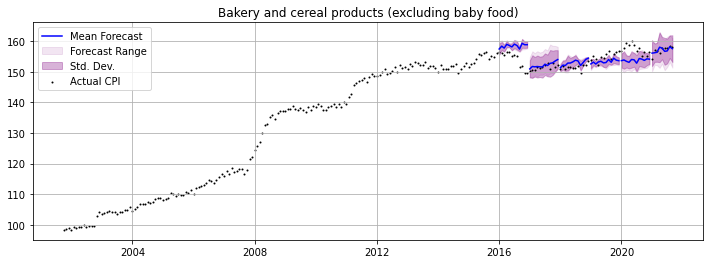

Dairy products and eggs
['neuralprophet_202110_CUSR0000SAF112_nlags_48', 'nbeats_202110']



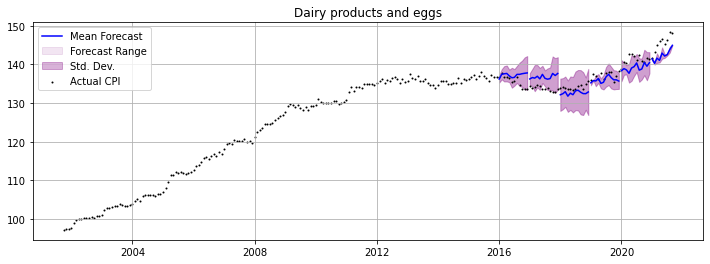

Fish, seafood and other marine products
['neuralprophet_202110_CUSR0000SAF113_nlags_48', 'nbeats_202110', 'neuralprophet_202110_QCAR368BIS_nlags_60']



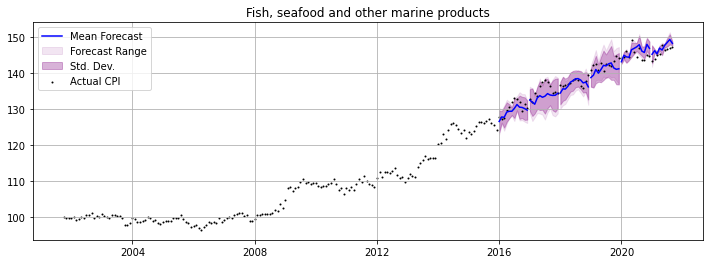

Food purchased from restaurants
['nbeatsfredvars_202110', 'nbeats_202110', 'neuralprophet_202110_WILL5000IND_nlags_36']



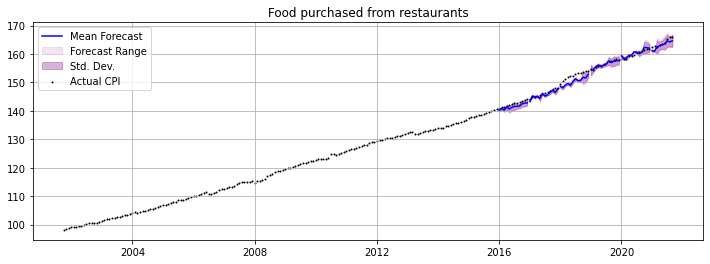

Food
['nbeatsfredvars_202110', 'neuralprophet_202110_CUSR0000SAF112_nlags_24', 'neuralprophet_202110_IRLTLT01CAM156N_nlags_60']



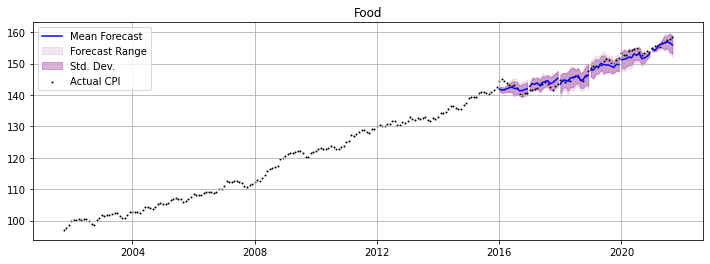

Fruit, fruit preparations and nuts
['neuralprophet_202110_CUSR0000SAF112_nlags_24', 'neuralprophet_202110_CUSR0000SAF112_nlags_36', 'neuralprophet_202110_CPALCY01CAM661N_nlags_24']



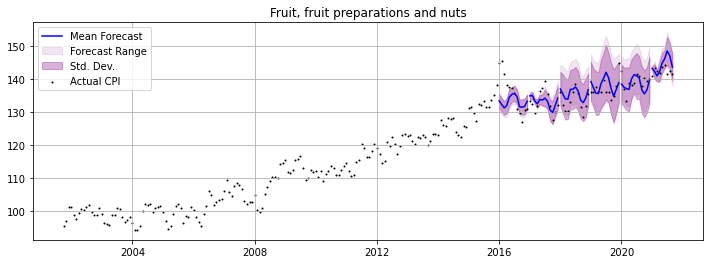

Meat
['nbeatsfredvars_202110', 'neuralprophet_202110_CUSR0000SAF112_nlags_24', 'nbeats_202110']



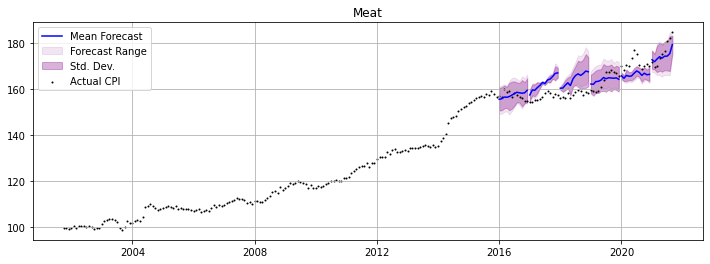

Other food products and non-alcoholic beverages
['neuralprophet_202110_VXOCLS_nlags_36', 'neuralprophet_202110_CUSR0000SAF112_nlags_24', 'prophet_202110']



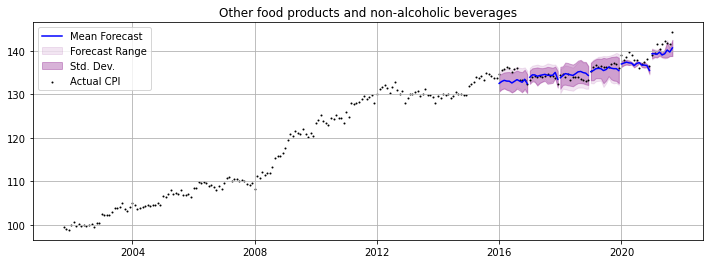

Vegetables and vegetable preparations
['neuralprophet_202110_DEXCAUS_nlags_24', 'neuralprophet_202110_WILL5000IND_nlags_60', 'neuralprophet_202110_CPGRLE01CAM657N_nlags_60']



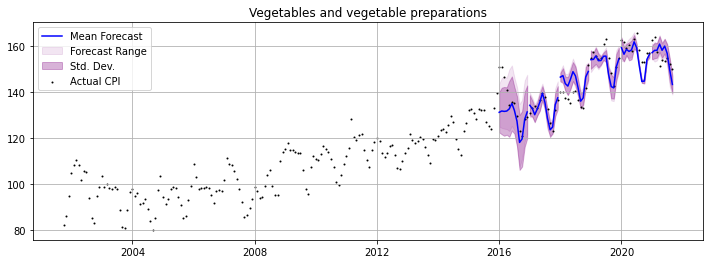

In [205]:
for category in food_categories:

    fig, ax = plt.subplots(figsize=(12,4))
    best_exp_config = category_config_scores[category].idxmin()['mape']
    best_exp_config = best_exp_config.replace("'",'').replace(' ', '').strip('()').split(',')
    best_exp_config = [config for config in best_exp_config if len(config) > 0]

    print(category)
    print(best_exp_config)
    print()

    for d_index, date in enumerate(report_sim_dates):

        all_forecasts = get_forecast_df(category, best_exp_config, date)
        all_forecasts = all_forecasts.loc[all_forecasts.index >= pd.to_datetime(date) + pd.DateOffset(months=6)]
        all_forecasts = all_forecasts.loc[all_forecasts.index < pd.to_datetime(date) + pd.DateOffset(months=18)]

        forecast_min = np.min(all_forecasts, axis=1) 
        forecast_std = np.std(all_forecasts, axis=1)
        forecast_mean = np.mean(all_forecasts, axis=1)
        forecast_max = np.max(all_forecasts, axis=1) 

        if d_index < 1:
            # ax.plot(all_forecasts.index, all_forecasts.mean(axis=1), color='red', label='Mean Forecast')
            ax.plot(all_forecasts.index, all_forecasts.mean(axis=1), color='blue', label='Mean Forecast')
            ax.fill_between(all_forecasts.index, forecast_min, forecast_max, alpha=0.1, color='purple', label='Forecast Range')
            ax.fill_between(all_forecasts.index, forecast_mean - forecast_std, forecast_mean + forecast_std, alpha=0.3, color='purple', label='Std. Dev.')
        else:
            # ax.plot(all_forecasts.index, all_forecasts.mean(axis=1), color='red')
            ax.plot(all_forecasts.index, all_forecasts.mean(axis=1), color='blue')
            ax.fill_between(all_forecasts.index, forecast_min, forecast_max, alpha=0.1, color='purple')
            ax.fill_between(all_forecasts.index,forecast_mean - forecast_std, forecast_mean + forecast_std, alpha=0.3, color='purple')

    ax.scatter(foodprice_df[category].index[-240:], foodprice_df[category].iloc[-240:], color='black', s=1, label="Actual CPI")
    plt.title(category)
    plt.legend(loc='upper left')
    plt.grid()
    plt.savefig(f"./report_output/ensemble_range_{category}.svg", bbox_inches='tight')
    plt.show()


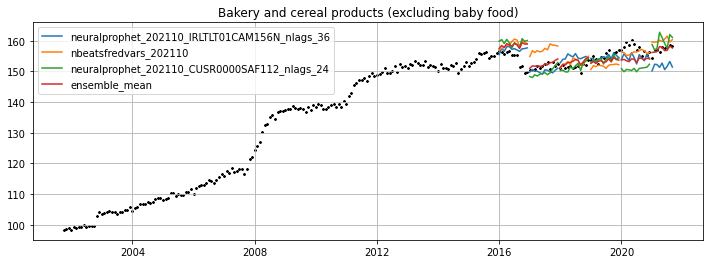

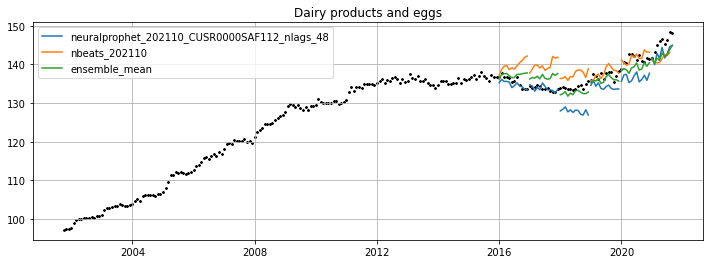

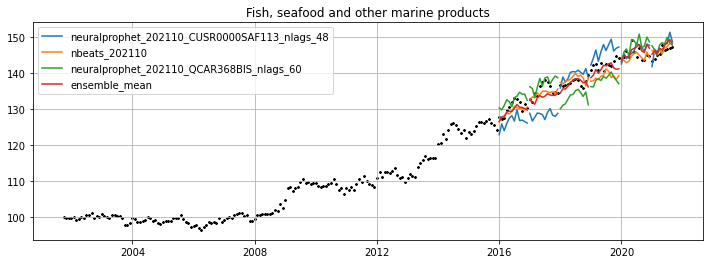

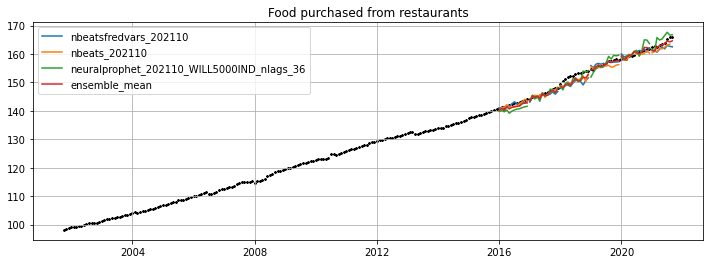

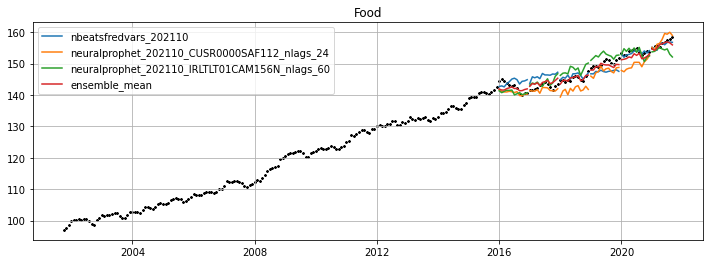

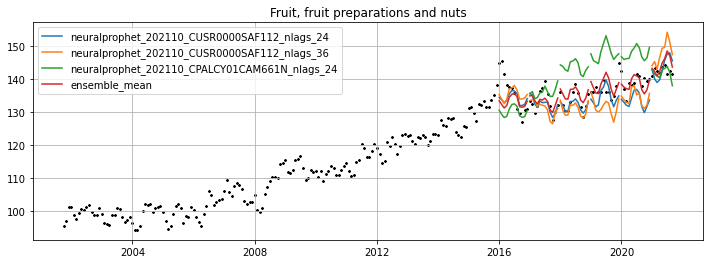

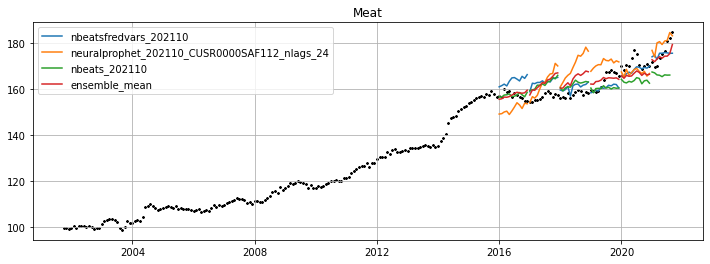

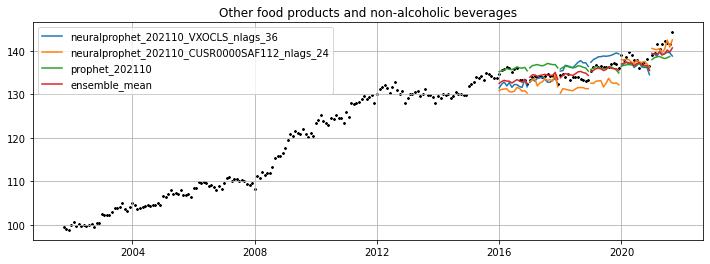

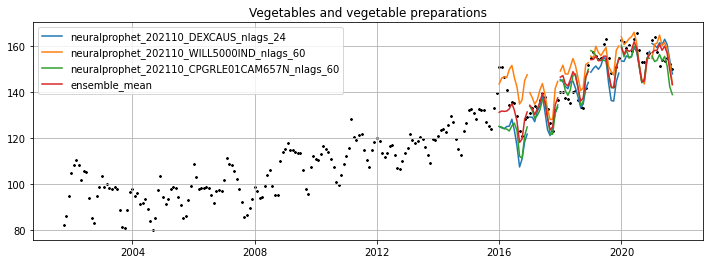

In [206]:
food_col_stats = {}

for category in food_categories:

    best_exp_config = category_config_scores[category].idxmin()['mape']
    best_exp_config = best_exp_config.replace("'",'').replace(' ', '').strip('()').split(',')
    best_exp_config = [config for config in best_exp_config if len(config) > 0]

    fig, ax = plt.subplots(figsize=(12,4))
    date_stats = []

    for d_index, date in enumerate(report_sim_dates):

        all_forecasts = get_forecast_df(category, best_exp_config, date)
        all_forecasts = all_forecasts.loc[all_forecasts.index >= pd.to_datetime(date) + pd.DateOffset(months=6)]
        all_forecasts = all_forecasts.loc[all_forecasts.index < pd.to_datetime(date) + pd.DateOffset(months=18)]
        all_forecasts = all_forecasts.assign(ensemble_mean=all_forecasts.mean(axis=1))

        ax.scatter(foodprice_df[category].index[-240:], foodprice_df[category].iloc[-240:], color='black', s=1)

        col_stats = {}

        for index, col in enumerate(all_forecasts):

            # Collect some stats
            y_pred = all_forecasts[col]
            y_true = foodprice_df[category].loc[y_pred.index]
            col_stats[col] = y_pred - y_true

            if d_index < 1:
                ax.plot(all_forecasts[col], color=f"C{index}", label=col)
            else:
                ax.plot(all_forecasts[col], color=f"C{index}")

        date_stats.append(pd.DataFrame(col_stats))
    
    food_col_stats[category] = pd.concat(date_stats, axis=0)

    plt.title(category)
    plt.legend(loc='best')
    plt.grid()
    plt.savefig(f"./report_output/ensemble_raw_{category}.svg", bbox_inches='tight')
    plt.show()


## Final forecast

In [18]:
def get_final_forecast_df(food_category, experiment_names):

    forecasts = []

    for ex_name in experiment_names:
        fc_df = pd.read_csv(f"./output/{ex_name}/fc_final.csv")
        if "REF_DATE" in fc_df.columns:
            fc_df = fc_df.set_index("REF_DATE")
        elif "Unnamed: 0" in fc_df.columns:
            fc_df = fc_df.set_index("Unnamed: 0")
        elif "ds" in fc_df.columns:
            fc_df = fc_df.set_index("ds")
        fc_df.index = pd.DatetimeIndex(fc_df.index)
        fc_series = fc_df[food_category]
        fc_series = fc_series.rename(ex_name)
        forecasts.append(fc_series)

    return pd.concat(forecasts, axis=1)

In [19]:
final_forecasts_df = get_final_forecast_df("Meat", experiment_names)
final_forecasts_df

FileNotFoundError: [Errno 2] No such file or directory: './output/neuralprophet_202110_DCOILWTICO_nlags_24/fc_final.csv'

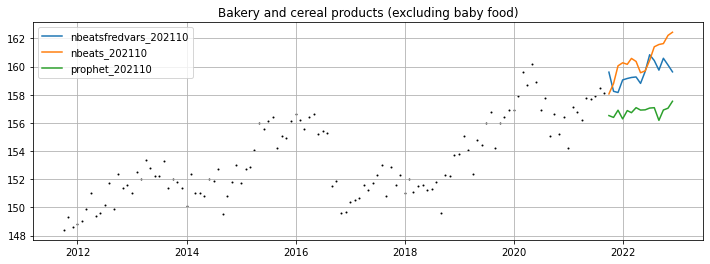

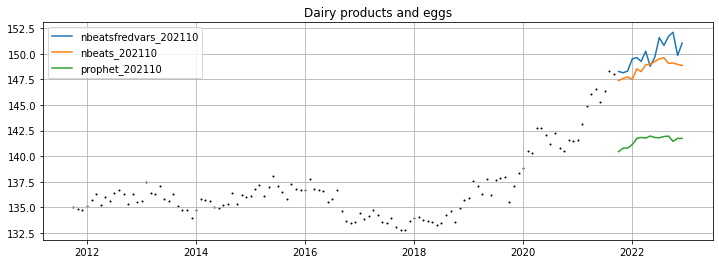

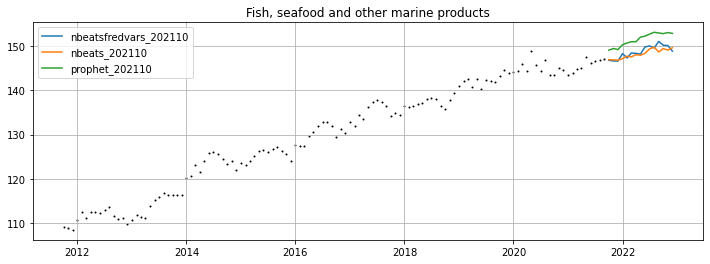

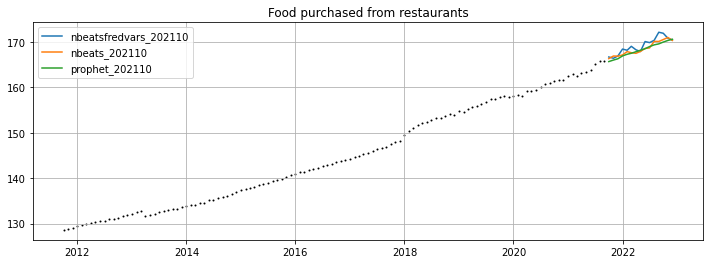

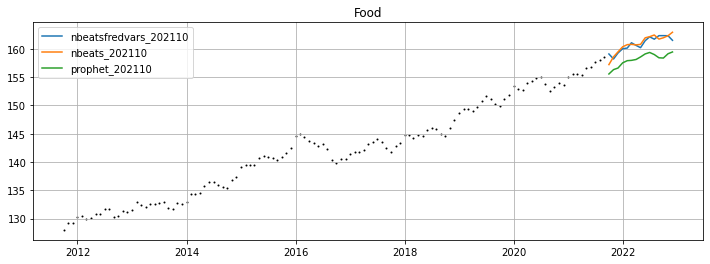

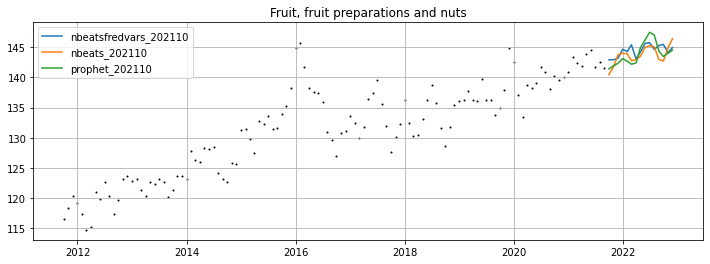

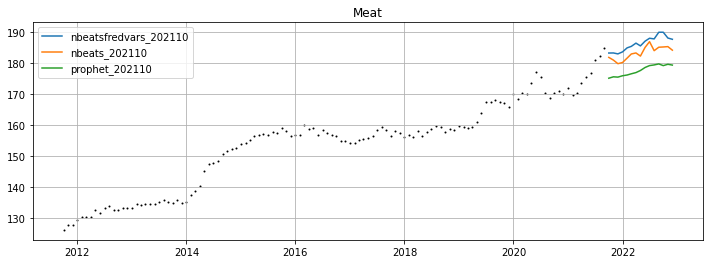

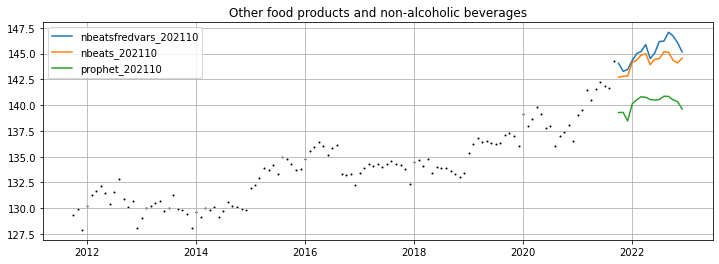

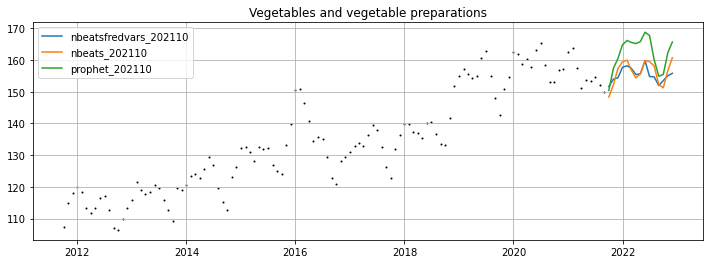

In [302]:
for category in food_categories:

    fig, ax = plt.subplots(figsize=(12,4))
    final_forecasts_df = get_final_forecast_df(category, experiment_names)
    final_forecasts_df = final_forecasts_df.loc[final_forecasts_df.index < "2023-01-01"]

    ax.scatter(foodprice_df[category].index[-120:], foodprice_df[category].iloc[-120:], color='black', s=1)
    for index, col in enumerate(final_forecasts_df):
        ax.plot(final_forecasts_df[col], color=f"C{index}", label=col)

    plt.title(category)
    plt.legend()
    plt.grid()
    plt.show()
    


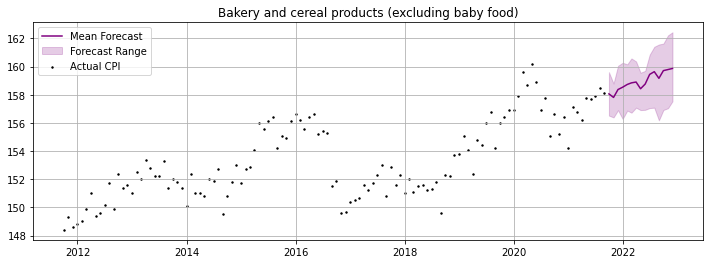

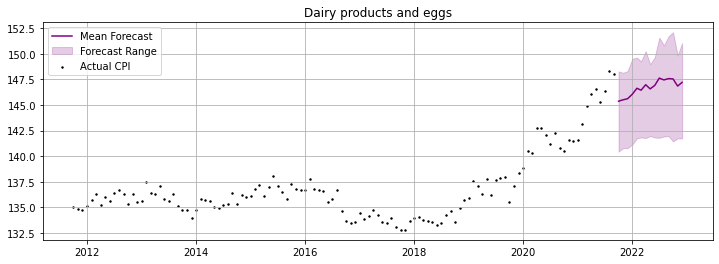

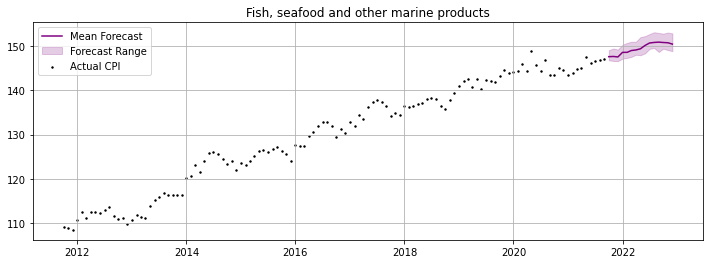

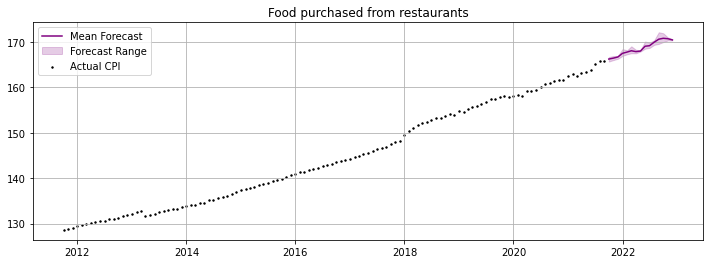

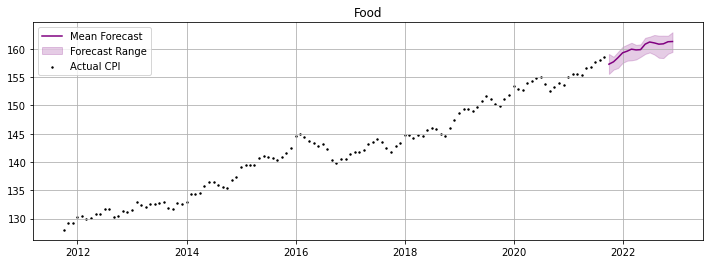

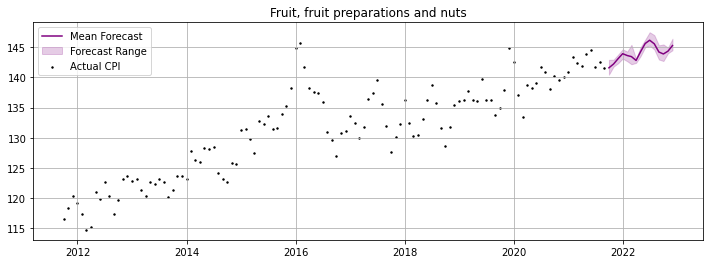

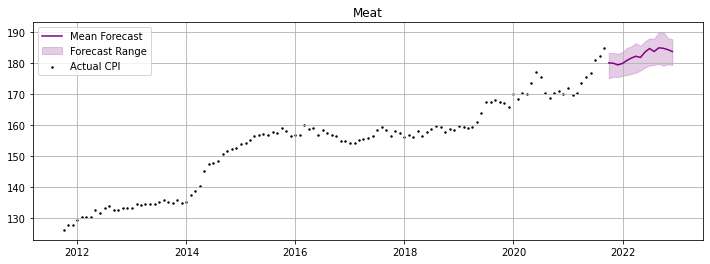

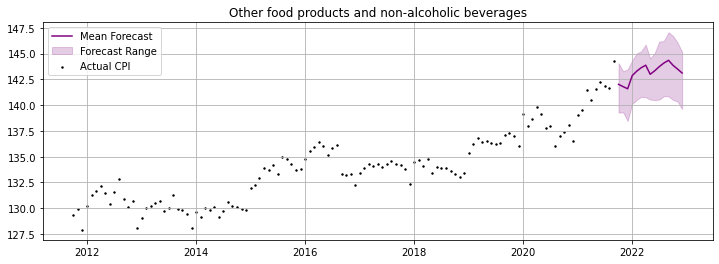

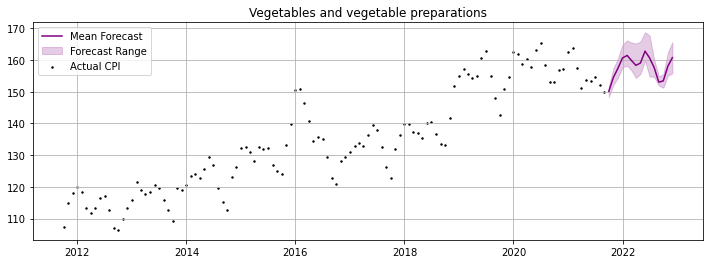

In [304]:
for category in food_categories:

    fig, ax = plt.subplots(figsize=(12,4))
    final_forecasts_df = get_final_forecast_df(category, experiment_names)
    final_forecasts_df = final_forecasts_df.loc[final_forecasts_df.index < "2023-01-01"]

    ax.plot(final_forecasts_df.mean(axis=1), color="purple", label="Mean Forecast")
    ax.fill_between(final_forecasts_df.mean(axis=1).index, final_forecasts_df.min(axis=1), final_forecasts_df.max(axis=1), color="purple", alpha=0.2, label='Forecast Range')
    ax.scatter(foodprice_df[category].index[-120:], foodprice_df[category].iloc[-120:], color='black', s=2, label='Actual CPI')

    plt.title(category)
    plt.legend(loc='upper left')
    plt.grid()
    plt.savefig(f"./report_output/ensemble_forecast_{category}.svg", bbox_inches='tight')
    plt.show()


## Forecast as Predicted Percent Change

Below we compute the expected change in CPI for 2022, relative to mean CPIs in 2021 so far. 

In [306]:
food_forecast_stats = {}
food_forecast_change_stats = {}

for category in food_categories:

    forecast_stats = {}
    forecast_change_stats = {}

    final_forecasts_df = get_final_forecast_df(category, experiment_names)
    final_forecasts_df = final_forecasts_df.loc[final_forecasts_df.index < "2023-01-01"]
    historical_cpi = foodprice_df[category]
    
    fc_min = final_forecasts_df.min(axis=1)
    fc_mean = final_forecasts_df.mean(axis=1)
    fc_max = final_forecasts_df.max(axis=1)

    forecast_stats['min'] = historical_cpi.append(fc_min)
    forecast_stats['mean'] = historical_cpi.append(fc_mean)
    forecast_stats['max'] = historical_cpi.append(fc_max)

    food_forecast_stats[category] = pd.DataFrame(forecast_stats)
    food_forecast_stats[category] = food_forecast_stats[category].loc[food_forecast_stats[category].index < "2023-01-01"]

    fc_stats = food_forecast_stats[category].iloc[-12:]
    historical_data = foodprice_df[category].iloc[-9:]

    forecast_change_stats['2021_mean'] = historical_data.mean()
    forecast_change_stats['2021_max'] = historical_data.max()
    forecast_change_stats['2022_fc_min'] = fc_stats.min().min() 
    forecast_change_stats['2022_fc_mean'] = fc_stats.mean().mean()
    forecast_change_stats['2022_fc_max'] = fc_stats.max().max()

    food_forecast_change_stats[category] = pd.Series(forecast_change_stats)


In [307]:
pd.set_option('display.float_format', lambda x: '%.1f' % x)

results_df = pd.DataFrame(food_forecast_change_stats).T
results_df

2021_mean  2021_max  \
Bakery and cereal products (excluding baby food)      157.1     158.5   
Dairy products and eggs                               145.6     148.3   
Fish, seafood and other marine products               145.7     147.6   
Food purchased from restaurants                       164.0     165.9   
Food                                                  156.6     158.5   
Fruit, fruit preparations and nuts                    142.5     144.5   
Meat                                                  176.1     184.8   
Other food products and non-alcoholic beverages       141.4     144.3   
Vegetables and vegetable preparations                 155.4     163.8   

                                                  2022_fc_min  2022_fc_mean  \
Bakery and cereal products (excluding baby food)        156.2         159.0   
Dairy products and eggs                                 141.1         146.4   
Fish, seafood and other marine products                 147.2         150.2   
Food purchased from restaurants                         167.0         169.2   
Food                                                    157.5         160.3   
Fruit, fruit preparations and nuts                      142.2         144.5   
Meat                                                    175.9         182.7   
Other food products and non-alcoholic beverages         139.6         143.2   
Vegetables and vegetable preparations                   151.3         159.3   

                                                  2022_fc_max  
Bakery and cereal products (excluding baby food)        162.4  
Dairy products and eggs                                 152.1  
Fish, seafood and other marine products                 153.2  
Food purchased from restaurants                         172.2  
Food                                                    162.9  
Fruit, fruit preparations and nuts                      147.5  
Meat                                                    189.9  
Other food products and non-alcoholic beverages         147.1  
Vegetables and vegetable preparations                   168.8

In [308]:
pct_change_from_mean_results = {}
pct_change_from_max_results = {}

for col in ['2022_fc_min', '2022_fc_mean', '2022_fc_max']:
    change = results_df[["2021_mean", col]].T.diff(1)
    pct_change_from_mean_results[col] = change.T[col]
    change = results_df[["2021_max", col]].T.diff(1)
    pct_change_from_max_results[col] = change.T[col]

In [309]:
pd.DataFrame(pct_change_from_mean_results)

2022_fc_min  2022_fc_mean  \
Bakery and cereal products (excluding baby food)         -1.0           1.8   
Dairy products and eggs                                  -4.5           0.8   
Fish, seafood and other marine products                   1.5           4.5   
Food purchased from restaurants                           3.0           5.3   
Food                                                      1.0           3.7   
Fruit, fruit preparations and nuts                       -0.3           2.0   
Meat                                                     -0.3           6.6   
Other food products and non-alcoholic beverages          -1.7           1.9   
Vegetables and vegetable preparations                    -4.2           3.9   

                                                  2022_fc_max  
Bakery and cereal products (excluding baby food)          5.3  
Dairy products and eggs                                   6.5  
Fish, seafood and other marine products                   7.4  
Food purchased from restaurants                           8.2  
Food                                                      6.4  
Fruit, fruit preparations and nuts                        5.0  
Meat                                                     13.8  
Other food products and non-alcoholic beverages           5.7  
Vegetables and vegetable preparations                    13.3

In [310]:
pd.DataFrame(pct_change_from_max_results)

2022_fc_min  2022_fc_mean  \
Bakery and cereal products (excluding baby food)         -2.3           0.5   
Dairy products and eggs                                  -7.2          -1.9   
Fish, seafood and other marine products                  -0.4           2.6   
Food purchased from restaurants                           1.1           3.3   
Food                                                     -1.0           1.8   
Fruit, fruit preparations and nuts                       -2.3          -0.0   
Meat                                                     -8.9          -2.1   
Other food products and non-alcoholic beverages          -4.7          -1.1   
Vegetables and vegetable preparations                   -12.5          -4.5   

                                                  2022_fc_max  
Bakery and cereal products (excluding baby food)          3.9  
Dairy products and eggs                                   3.8  
Fish, seafood and other marine products                   5.6  
Food purchased from restaurants                           6.3  
Food                                                      4.4  
Fruit, fruit preparations and nuts                        3.0  
Meat                                                      5.1  
Other food products and non-alcoholic beverages           2.8  
Vegetables and vegetable preparations                     5.0

## Percent change of 2021 data compared to 2020

In [214]:
mean_2021 = foodprice_df.iloc[-9:].mean(axis=0)
mean_2020 = foodprice_df.iloc[-9-12:-9].mean(axis=0)
(pd.concat((mean_2020, mean_2021), axis=1).T).diff().T


0    1
Bakery and cereal products (excluding baby food) NaN -0.4
Dairy products and eggs                          NaN  4.3
Fish, seafood and other marine products          NaN  0.6
Food purchased from restaurants                  NaN  4.0
Food                                             NaN  2.8
Fruit, fruit preparations and nuts               NaN  3.4
Meat                                             NaN  4.9
Other food products and non-alcoholic beverages  NaN  3.4
Vegetables and vegetable preparations            NaN -3.6